In [0]:
# Change directory to VSCode workspace root so that relative path loads work correctly. Turn this addition off with the DataScience.changeDirOnImportExport setting
# ms-python.python added
import os
try:
	os.chdir(os.path.join(os.getcwd(), '..'))
	print(os.getcwd())
except:
	pass


In [1]:
from keras.applications import inception_v3
from keras import backend as K

K.set_learning_phase(0)

model = inception_v3.InceptionV3(weights='imagenet',
                                 include_top=False)


Using TensorFlow backend.


Instructions for updating:
Colocations handled automatically by placer.


In [2]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
from keras.utils import plot_model
SVG(model_to_dot(model, show_shapes=True).create(prog='dot', format='svg'))
plot_model(model, show_shapes=True)


In [3]:
layer_contributions = {
    'mixed4': 0.2,
    'mixed5': 3.,
    'mixed6': 2.,
    'mixed7': 1.5
}

layer_dict = dict([(layer.name, layer) for layer in model.layers])

loss = K.variable(0)
for layer_name in layer_contributions:
    coeff = layer_contributions[layer_name]
    activation = layer_dict[layer_name].output

    scaling = K.prod(K.cast(K.shape(activation), 'float32'))
    loss += coeff * K.sum(K.square(activation[:, 2:-2, 2:-2, :])) / scaling


In [4]:
dream = model.input

grads = K.gradients(loss, dream)[0]
grads /= K.maximum(K.mean(K.abs(grads)), 1e-7)

outputs = [loss, grads]
fetch_loss_and_grads = K.function([dream], outputs)


def eval_loss_and_grads(x):
    outs = fetch_loss_and_grads([x])
    loss_value = outs[0]
    grad_values = outs[1]
    return loss_value, grad_values


def gradient_ascent(x, iterations, step, max_loss=None):
    for i in range(iterations):
        loss_value, grad_values = eval_loss_and_grads(x)
        print(loss_value)
        if max_loss is not None and loss_value > max_loss:
            break
        print('...Loss value at', i, ':', loss_value)
        x += step * grad_values
    return x


In [5]:
import numpy as np
import scipy
from keras.preprocessing import image


def resize_img(img, size):
    img = np.copy(img)
    factors = (1,
               float(size[0]) / img.shape[1],
               float(size[1]) / img.shape[2],
               1)
    return scipy.ndimage.zoom(img, factors, order=1)


def save_img(img, fname):
    pil_img = deprocess_image(np.copy(img))
    scipy.misc.imsave(fname, pil_img)


def preprocess_image(image_path):
    img = image.load_img(image_path)
    img = image.img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = inception_v3.preprocess_input(img)
    return img


def deprocess_image(x):
    if K.image_data_format() == 'channels_first':
        x = x.reshape((3, x.shape[2], x.shape[3]))
        x = x.transpose((1, 2, 0))
    else:
        x = x.reshape((x.shape[1], x.shape[2], 3))

    x /= 2.
    x += 0.5
    x *= 255.
    x = np.clip(x, 0, 255).astype('uint8')
    return x


In [6]:
import os
try:
    os.chdir(os.path.join(os.getcwd(), 'chapter8'))
    print(os.getcwd())
except:
    pass


/Users/remi/Desktop/projects/keras/chapter8


In [7]:
step = 0.01
num_octave = 3
octave_scale = 1.4
iterations = 20

max_loss = 10.

base_image_path = "lastjedi.jpg"

img = preprocess_image(base_image_path)

original_shape = img.shape[1:3]
successive_shapes = [original_shape]
for i in range(1, num_octave):
    shape = tuple([int(dim / (octave_scale ** i))
        for dim in original_shape])
    successive_shapes.append(shape)

successive_shapes = successive_shapes[::-1]
print(successive_shapes)


[(278, 653), (390, 914), (546, 1280)]


In [8]:
original_img = np.copy(img)
shrunk_original_img = resize_img(img, successive_shapes[0])

for shape in successive_shapes:
    print('Processing image shape', shape)
    img = resize_img(img, shape)
    img = gradient_ascent(img,
                          iterations=iterations,
                          step=step,
                          max_loss=max_loss)
    upscaled_skrunk_original_img = resize_img(shrunk_original_img, shape)
    same_size_original = resize_img(original_img, shape)
    lost_detail = same_size_original - upscaled_skrunk_original_img

    img += lost_detail
    shrunk_original_img = resize_img(original_img, shape)
    save_img(img, fname='dream_at_scale_' + str(shape) + '.png')

save_img(img, fname='final_dream.png')


Processing image shape (278, 653)
0.73596364
...Loss value at 0 : 0.73596364
0.88376015
...Loss value at 1 : 0.88376015
1.1179309
...Loss value at 2 : 1.1179309
1.3624856
...Loss value at 3 : 1.3624856
1.6081274
...Loss value at 4 : 1.6081274
1.8228718
...Loss value at 5 : 1.8228718
2.0483718
...Loss value at 6 : 2.0483718
2.2447267
...Loss value at 7 : 2.2447267
2.4641676
...Loss value at 8 : 2.4641676
2.668746
...Loss value at 9 : 2.668746
2.8771915
...Loss value at 10 : 2.8771915
3.1043274
...Loss value at 11 : 3.1043274
3.3048544
...Loss value at 12 : 3.3048544
3.4732232
...Loss value at 13 : 3.4732232
3.7205684
...Loss value at 14 : 3.7205684
3.9013712
...Loss value at 15 : 3.9013712
4.161678
...Loss value at 16 : 4.161678
4.355412
...Loss value at 17 : 4.355412
4.573318
...Loss value at 18 : 4.573318
4.839508
...Loss value at 19 : 4.839508
Processing image shape (390, 914)
1.155506
...Loss value at 0 : 1.155506
1.7814981
...Loss value at 1 : 1.7814981
2.2610223
...Loss value at 2

/Users/remi/.local/share/virtualenvs/keras-uVvfbwDn/lib/python3.7/site-packages/ipykernel_launcher.py:17: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.


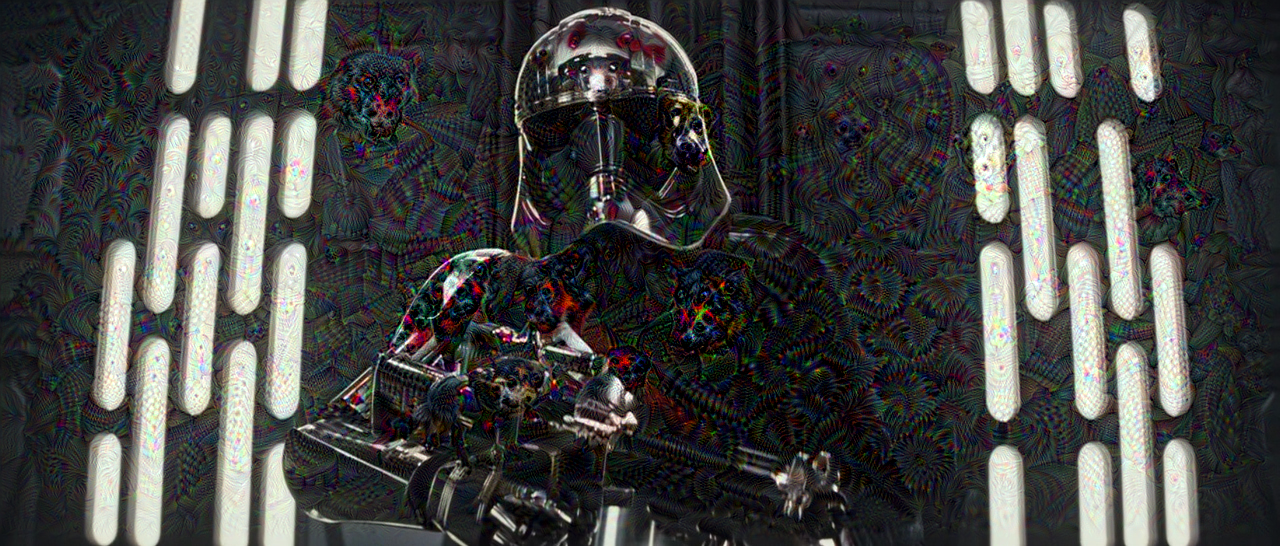

In [9]:
from IPython.display import Image
Image(filename='final_dream.png')